In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2003 - val_loss: 0.1378
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1258 - val_loss: 0.0727
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - val_loss: 0.0615
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0533
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.0405
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - val_loss: 0.0310
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0231
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0180
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0151
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

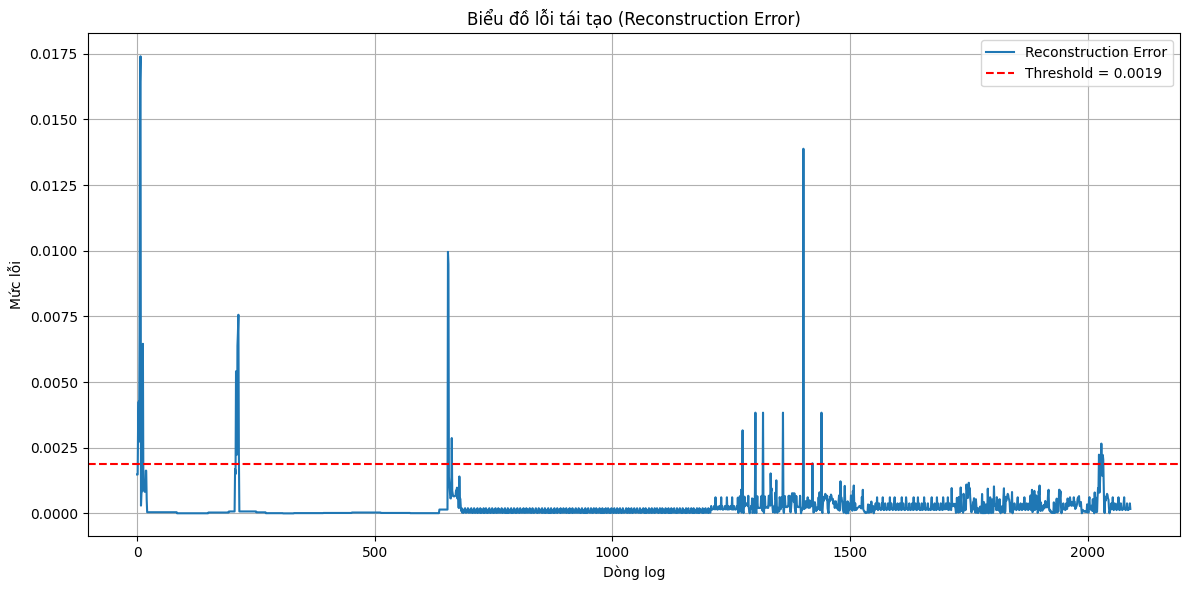

In [ ]:

# 1. Đọc và xử lý dữ liệu
df = pd.read_csv('./data/processed_access_log.csv')  # Dùng / cho path tương thích Unix & Windows
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
df = df.dropna(subset=['datetime'])  # Bỏ dòng không parse được
df['hour'] = df['datetime'].dt.hour

# 2. Mã hóa các cột
label_encoders = {}
for col in ['ip', 'method', 'path', 'referrer', 'user_agent']:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col + '_enc'] = le.fit_transform(df[col])
    label_encoders[col] = le

# 3. Chọn đặc trưng đầu vào
feature_columns = ['ip_enc', 'method_enc', 'path_enc', 'status', 'size', 'referrer_enc', 'user_agent_enc', 'hour']
features = df[feature_columns]

# 4. Chuẩn hóa
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# 5. Xây mô hình Autoencoder
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 6. Huấn luyện mô hình
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# 7. Dự đoán và đánh giá lỗi
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = tf.keras.losses.mse(X_scaled, reconstructions).numpy()

# 8. Ngưỡng phát hiện bất thường
threshold = reconstruction_errors.mean() + 2 * reconstruction_errors.std()
df['reconstruction_error'] = reconstruction_errors
df['anomaly'] = df['reconstruction_error'] > threshold

# 9. In kết quả
anomalies = df[df['anomaly']]
print("✅ Số dòng bất thường phát hiện:", len(anomalies))
print(anomalies[['ip', 'datetime', 'method', 'path', 'status', 'size', 'reconstruction_error']])

# 10. Lưu mô hình và preprocessing
autoencoder.save('./model/autoencoder_model.keras')
joblib.dump(scaler, './model/scaler.pkl')
joblib.dump(label_encoders, './model/label_encoders.pkl')
joblib.dump(threshold, './model/reconstruction_threshold.pkl')

# 11. Vẽ biểu đồ reconstruction error
plt.figure(figsize=(12, 6))
plt.plot(df['reconstruction_error'], label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Biểu đồ lỗi tái tạo (Reconstruction Error)')
plt.xlabel('Dòng log')
plt.ylabel('Mức lỗi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./model/reconstruction_error_plot.png')
plt.show()